# Client Churn Prediction
### CRISP-DM Cycle 3
---

> Disclaimer: This is a fictional bussiness case

## Settings

In [1]:
# Settings imports
import os
import sys
import h2o

from dotenv import load_dotenv

# Load .env file
env_path = "../.env"
load_dotenv(dotenv_path=env_path)

# Seed
seed = int(os.getenv("SEED"))

# Add path
path = os.getenv("HOMEPATH")

# Add path to sys.path
sys.path.append(path)

In [2]:
import pandas as pd
from h2o.automl import H2OAutoML
from helpers.classes.FeatureEngineering import FeatureEngineering
from helpers.classes.Queries import DuckQueries

## Data

This dataset is avaliable [here](https://www.kaggle.com/mervetorkan/churndataset).


**Data fields**

- **RowNumber**: the number of the columns
- **CustomerID**: unique identifier of clients
- **Surname**: client's last name
- **CreditScore**: clien'ts credit score for the financial market
- **Geography**: the country of the client
- **Gender**: the gender of the client
- **Age**: the client's age
- **Tenure**: number of years the client is in the bank 
- **Balance**: the amount that the client has in their account 
- **NumOfProducts**: the number of products that the client bought 
- **HasCrCard**: if the client has a credit card 
- **IsActiveMember**: if the client is active (within the last 12 months) 
- **EstimateSalary**: estimative of anual salary of clients 
- **Exited**: if the client is a churn (*target variable*)

In [3]:
qb = DuckQueries()
conn = qb.get_connection(path + "/data/interim/churn.db")

query = qb.select("*").from_table("churn").build()
data = conn.execute(query).df()
conn.close()

fe = FeatureEngineering(seed=seed)
X_train, X_test, X_val, y_train, y_test, y_val, id_train, id_test, id_val = (
    fe.transform(data)
)

## AutoML

In [4]:
h2o.init(ip="localhost", port=54321)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "21.0.1" 2023-10-17; OpenJDK Runtime Environment (build 21.0.1+12-29); OpenJDK 64-Bit Server VM (build 21.0.1+12-29, mixed mode, sharing)
  Starting server from /Users/guttofranca/Repos/churn-prediction/.venv/lib/python3.12/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/k8/xr4_svzj4l705syzgn21x_500000gn/T/tmpl9gaoulf
  JVM stdout: /var/folders/k8/xr4_svzj4l705syzgn21x_500000gn/T/tmpl9gaoulf/h2o_guttofranca_started_from_python.out
  JVM stderr: /var/folders/k8/xr4_svzj4l705syzgn21x_500000gn/T/tmpl9gaoulf/h2o_guttofranca_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/Recife
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,1 month and 20 days
H2O_cluster_name:,H2O_from_python_guttofranca_1dgodk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.984 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [5]:
# Create a pandas dataframe
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)

# Convert to h2o frame
train_h2o = h2o.H2OFrame(train_df)
test_h2o = h2o.H2OFrame(test_df)
val_h2o = h2o.H2OFrame(val_df)

# Target column
target_column = train_h2o.columns[-1]
train_h2o[target_column] = train_h2o[target_column].asfactor()
test_h2o[target_column] = test_h2o[target_column].asfactor()
val_h2o[target_column] = val_h2o[target_column].asfactor()

# Feature columns
feature_columns = train_h2o.columns[:-1]

# Run AutoML
aml = H2OAutoML(
    max_models=30,
    seed=seed,
    max_runtime_secs=1800,
    project_name="churn_automl",
    stopping_metric="logloss",
    sort_metric="aucpr",
)

aml.train(
    x=feature_columns,
    y=target_column,
    training_frame=train_h2o,
    leaderboard_frame=val_h2o,
)

lb = aml.leaderboard
lb.head(rows=lb.nrows)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
14:38:11.128: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


model_id,aucpr,auc,logloss,mean_per_class_error,rmse,mse
GBM_grid_1_AutoML_1_20240504_143811_model_5,0.74424,0.870819,0.320284,0.21831,0.308103,0.0949272
GBM_3_AutoML_1_20240504_143811,0.74303,0.873922,0.320832,0.219061,0.308848,0.0953873
GBM_2_AutoML_1_20240504_143811,0.740166,0.876472,0.319461,0.211018,0.309257,0.0956397
GBM_grid_1_AutoML_1_20240504_143811_model_7,0.737233,0.871382,0.327352,0.201202,0.312098,0.0974049
GBM_grid_1_AutoML_1_20240504_143811_model_4,0.733496,0.872035,0.324893,0.211326,0.311555,0.0970663
GBM_grid_1_AutoML_1_20240504_143811_model_6,0.732369,0.874458,0.325087,0.200266,0.311552,0.0970643
GBM_1_AutoML_1_20240504_143811,0.731537,0.876817,0.323477,0.205735,0.311509,0.0970376
GBM_4_AutoML_1_20240504_143811,0.731065,0.87641,0.322501,0.223212,0.311291,0.0969021
DRF_1_AutoML_1_20240504_143811,0.7265,0.869088,0.363342,0.228742,0.317486,0.100797
GBM_grid_1_AutoML_1_20240504_143811_model_1,0.72618,0.863887,0.331537,0.22044,0.314759,0.0990731


In [6]:
best_model = aml.leader
# Obter a importância das variáveis
feature_importance = best_model.varimp(use_pandas=True)

# Mostrar as características mais importantes
print(feature_importance)

                        variable  relative_importance  scaled_importance  \
0                    age_squared           604.003540           1.000000   
1                            age           365.390930           0.604948   
2   credit_score_num_of_products           310.314453           0.513763   
3                num_of_products           301.617004           0.499363   
4               engagement_score           239.261322           0.396126   
5         credit_score_age_ratio           171.615387           0.284130   
6               is_active_member           164.549850           0.272432   
7      customer_value_normalized           158.298996           0.262083   
8                        balance           147.048828           0.243457   
9                      geography           144.798355           0.239731   
10               product_density           129.396271           0.214231   
11         salary_rank_geography           128.027847           0.211965   
12          

In [7]:
params = best_model.get_params()
print(params)

{'model_id': None, 'training_frame': None, 'validation_frame': None, 'nfolds': 0, 'keep_cross_validation_models': True, 'keep_cross_validation_predictions': False, 'keep_cross_validation_fold_assignment': False, 'score_each_iteration': False, 'score_tree_interval': 0, 'fold_assignment': 'auto', 'fold_column': None, 'response_column': None, 'ignored_columns': None, 'ignore_const_cols': True, 'offset_column': None, 'weights_column': None, 'balance_classes': False, 'class_sampling_factors': None, 'max_after_balance_size': 5.0, 'max_confusion_matrix_size': 20, 'ntrees': 50, 'max_depth': 5, 'min_rows': 10.0, 'nbins': 20, 'nbins_top_level': 1024, 'nbins_cats': 1024, 'r2_stopping': None, 'stopping_rounds': 0, 'stopping_metric': 'auto', 'stopping_tolerance': 0.001, 'max_runtime_secs': 0.0, 'seed': -1, 'build_tree_one_node': False, 'learn_rate': 0.1, 'learn_rate_annealing': 1.0, 'distribution': 'auto', 'quantile_alpha': 0.5, 'tweedie_power': 1.5, 'huber_alpha': 0.9, 'checkpoint': None, 'sample_

In [8]:
best_model.summary()

,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,37.0,37.0,79718.0,9.0,9.0,9.0,110.0,215.0,166.94595


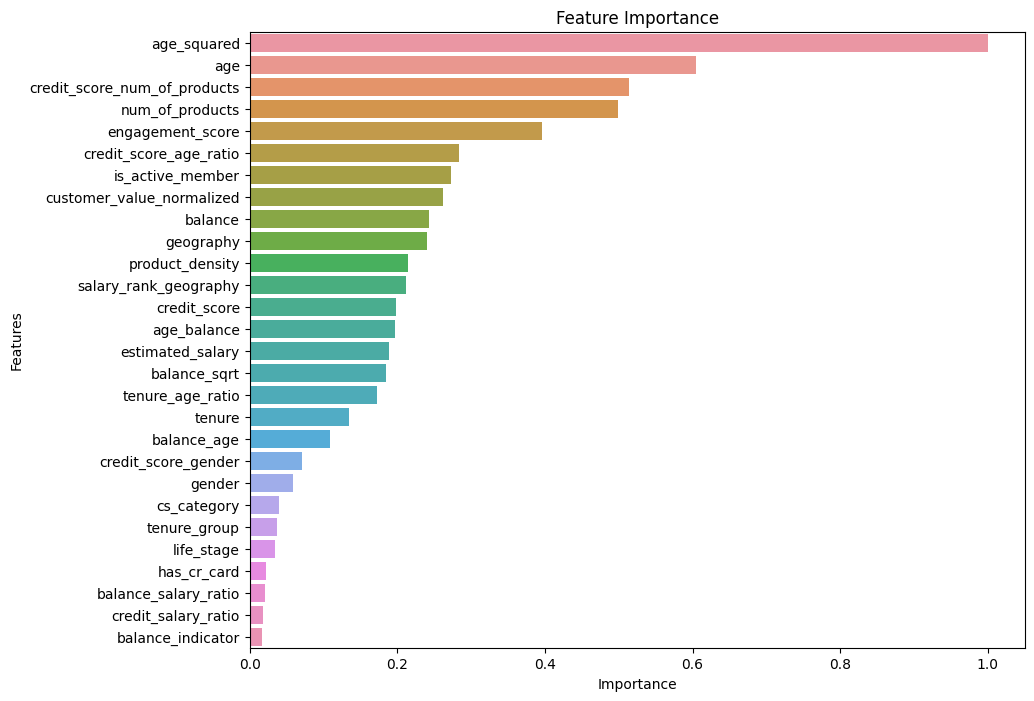

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico de barras das importâncias das características
plt.figure(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=feature_importance)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [10]:
h2o.cluster().shutdown()

H2O session _sid_8825 closed.
